https://wikidocs.net/59427

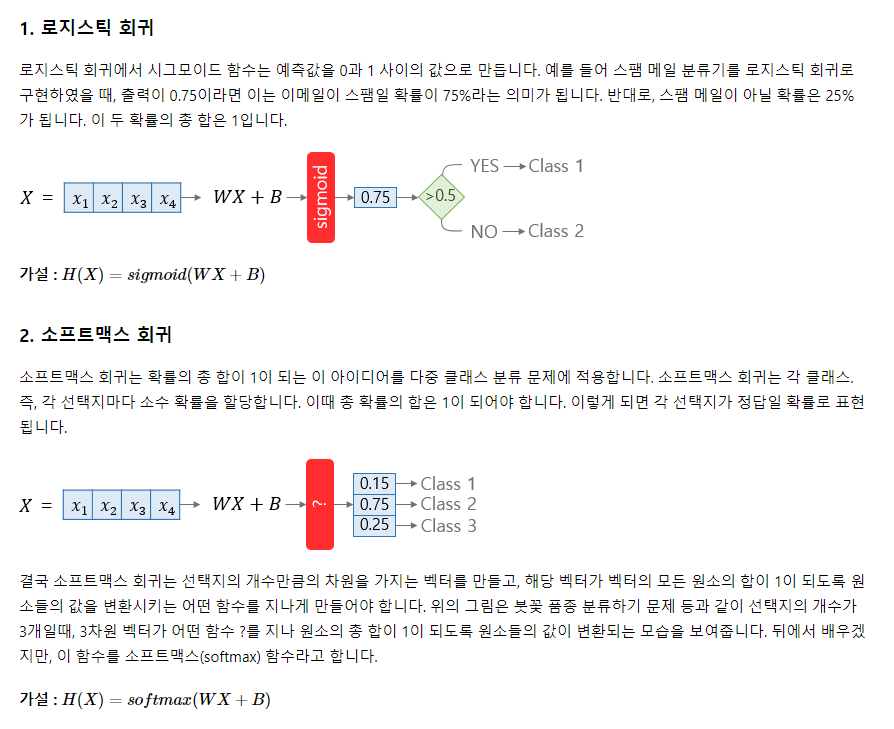

In [1]:
import torch
import torch.nn.functional as F
torch.manual_seed(1)

### 1. 파이토치로 소프트맥스의 비용 함수 구현하기 (로우-레벨)
소프트맥스 회귀를 구현함에 있어 우선 소프트맥스 함수의 비용 함수를 로우-레벨로 구현해봅시다.
3개의 원소를 가진 벡터 텐서를 정의하고, 이 텐서를 통해 소프트맥스 함수를 이해해보겠습니다.

In [2]:
z = torch.FloatTensor([1, 2, 3])

In [3]:
hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


3개의 원소의 값이 0과 1사이의 값을 가지는 벡터로 변환된 것을 볼 수 있습니다. 이 원소들의 값의 합이 1인지 확인해보겠습니다.

In [4]:
hypothesis.sum()

tensor(1.)

총 원소의 값의 합은 1입니다. 이번에는 비용 함수를 직접 구현해보겠습니다. 우선 임의의 3 × 5 행렬의 크기를 가진 텐서를 만듭니다.

In [8]:
z = torch.rand(3, 5, requires_grad=True)
print(z)

tensor([[0.7570, 0.2346, 0.6471, 0.3556, 0.4452],
        [0.0193, 0.2616, 0.7713, 0.3785, 0.9980],
        [0.9008, 0.4766, 0.1663, 0.8045, 0.6552]], requires_grad=True)


이제 이 텐서에 대해서 소프트맥스 함수를 적용합니다. 단, 각 샘플에 대해서 소프트맥스 함수를 적용하여야 하므로 두번째 차원에 대해서 소프트맥스 함수를 적용한다는 의미에서 dim=1을 써줍니다

In [9]:
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.2570, 0.1524, 0.2303, 0.1721, 0.1882],
        [0.1178, 0.1501, 0.2499, 0.1687, 0.3135],
        [0.2615, 0.1711, 0.1254, 0.2375, 0.2045]], grad_fn=<SoftmaxBackward0>)


이제 각 행의 원소들의 합은 1이 되는 텐서로 변환되었습니다. 소프트맥스 함수의 출력값은 결국 예측값입니다. 즉, 위 텐서는 3개의 샘플에 대해서 5개의 클래스 중 어떤 클래스가 정답인지를 예측한 결과입니다.

In [23]:
y = torch.randint(5, (3,)).long()
print(y)

tensor([2, 3, 3])


In [24]:
# 이제 각 레이블에 대해서 원-핫 인코딩을 수행합니다.

# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis) 
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]])

In [25]:
print(y.unsqueeze(1))

tensor([[2],
        [3],
        [3]])


그리고 scatter의 첫번째 인자로 dim=1에 대해서 수행하라고 알려주고, 세번째 인자에 숫자 1을 넣어주므로서 두번째 인자인 y_unsqeeze(1)이 알려주는 위치에 숫자 1을 넣도록 합니다. 앞서 텐서 조작하기 2챕터에서 연산 뒤에 _를 붙이면 In-place Operation (덮어쓰기 연산)임을 배운 바 있습니다. 이에 따라서 y_one_hot의 최종 결과는 결국 아래와 같습니다.

In [26]:
print(y_one_hot)

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]])


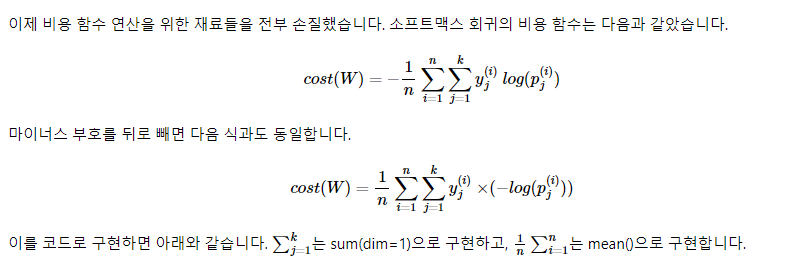

In [27]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.5619, grad_fn=<MeanBackward0>)


### 2. 파이토치로 소프트맥스의 비용 함수 구현하기 (하이-레벨)
이제 소프트맥스의 비용 함수를 좀 더 하이-레벨로 구현하는 방법에 대해서 알아봅시다.

1. F.softmax() + torch.log() = F.log_softmax()
앞서 소프트맥스 함수의 결과에 로그를 씌울 때는 다음과 같이 소프트맥스 함수의 출력값을 로그 함수의 입력으로 사용했습니다.

In [28]:
# Low level
torch.log(F.softmax(z, dim=1))

tensor([[-1.3585, -1.8809, -1.4685, -1.7599, -1.6704],
        [-2.1387, -1.8964, -1.3867, -1.7796, -1.1600],
        [-1.3414, -1.7656, -2.0759, -1.4377, -1.5870]], grad_fn=<LogBackward0>)

그런데 파이토치에서는 두 개의 함수를 결합한 F.log_softmax()라는 도구를 제공합니다.



In [29]:
# High level
F.log_softmax(z, dim=1)

tensor([[-1.3585, -1.8809, -1.4685, -1.7599, -1.6704],
        [-2.1387, -1.8964, -1.3867, -1.7796, -1.1600],
        [-1.3414, -1.7656, -2.0759, -1.4377, -1.5870]],
       grad_fn=<LogSoftmaxBackward0>)

2. F.log_softmax() + F.nll_loss() = F.cross_entropy()
앞서 로우-레벨로 구현한 비용 함수는 다음과 같았습니다.

In [30]:
# Low level
# 첫번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.5619, grad_fn=<MeanBackward0>)

그런데 위의 수식에서 torch.log(F.softmax(z, dim=1))를 방금 배운 F.log_softmax()로 대체할 수 있습니다.

In [31]:
# 두번째 수식
(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.5619, grad_fn=<MeanBackward0>)

이를 더 간단하게 하면 다음과 같습니다. F.nll_loss()를 사용할 때는 원-핫 벡터를 넣을 필요없이 바로 실제값을 인자로 사용합니다.

In [32]:
# High level
# 세번째 수식
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.5619, grad_fn=<NllLossBackward0>)

여기서 nll이란 Negative Log Likelihood의 약자입니다. 위에서 nll_loss는 F.log_softmax()를 수행한 후에 남은 수식들을 수행합니다. 이를 더 간단하게 하면 다음과 같이 사용할 수 있습니다. F.cross_entropy()는 F.log_softmax()와 F.nll_loss()를 포함하고 있습니다.

In [33]:
# 네번째 수식
F.cross_entropy(z, y)

tensor(1.5619, grad_fn=<NllLossBackward0>)